In [2]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *

In [3]:
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
f  = 0.7 * 2 * np.pi  # external field

n_th_a = 0.0           # temperature in frequency units

tlist = np.linspace(0,50,5000)

In [9]:
N_states = 5
ng_steps = 300

#
def njjp1(j,Ej,Ec):
    return ((j+1)/2)**0.5*(Ej/2/Ec)**0.25

def projector(N,n,m):
    # |m><n| operator
    a = np.zeros((N,N),dtype = np.float64)
    if(n >= N or n < 0 or m >= N or m < 0):
        return Qobj(a)
    a[n,m] = 1
    return Qobj(a)
#
def projector_pm(N,n,m):
    a = np.zeros((2*N+1,2*N+1),dtype = np.float64)
    if(n > N or n < -N or m > N or m < -N):
        return Qobj(a)
    a[N+n,N+m] = 1
    return Qobj(a)

#
def num_pm(N):
    return num(2*N+1, offset = -N)    
def zero_pm(N):
    return zero_oper(2*N+1)

In [40]:
Ec = wa
Ej = 2.5*Ec
N_states = 20
n = num_pm(N_states)
ng = 0
Hc = Ec*(n-ng)**2

f = Ec
Hj = zero_pm(N_states)
C = zero_pm(N_states)
for n in range(-N_states,N_states+1):
    Hj = Hj - 0.5*Ej*(projector_pm(N_states,n,n+1) + projector_pm(N_states,n+1,n))
    C = C + njjp1(abs(n),Ej,Ec)/njjp1(0,Ej,Ec)*projector_pm(N_states,n+1,n)
Hq = Hj + Hc

n = num_pm(N_states)
Hf = f * n
Hf_coeff_cython = "sin(t * w + phi)"
Args = {'w' : 1.5*wa, 'phi' : 0}

def Hf_coeff_python(t, args):
    return np.sin(t * args['w'] + args['phi'])

psi0 = basis(2*N_states+1,0)
tlist = np.linspace(0,30,100)

In [41]:
c_op_list = []

gamma_relax = 0.00
gamma_dephase_m = 0.02
gamma_dephase_p = 0.02


rate = gamma_dephase_m
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * C)

rate = gamma_dephase_p
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * C.dag())


rate = gamma_relax/2
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * num_pm(N_states))

In [43]:
%%time
H = [Hq, [Hf, Hf_coeff_cython]]
output = mesolve(H, psi0, tlist, c_op_list, [num_pm(N_states)], args = Args,options= Options(nsteps=10000))

CPU times: user 1min 6s, sys: 36 ms, total: 1min 7s
Wall time: 1min 8s


In [ ]:
%%time
H = [Hq, [Hf, Hf_coeff_python]]
output = mesolve(H, psi0, tlist, c_op_list, [num_pm(n_states)], args = Args)

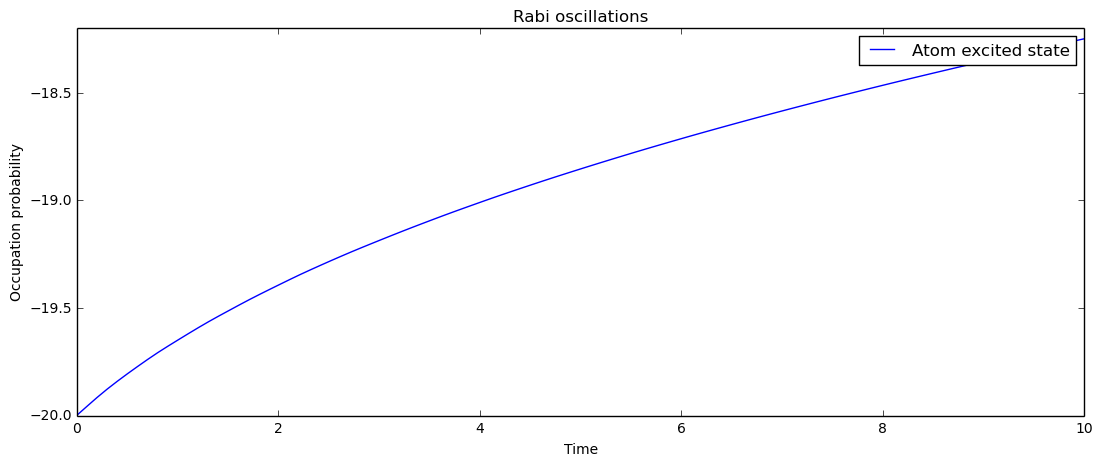

In [39]:
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(tlist, output.expect[0], label="Atom excited state")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Rabi oscillations');